### **Proposed Experiment: Impact of Lane Preference Reward on Agent Behavior**

#### **Motivation & Hypothesis**

The original reward structure incentivizes staying in the **rightmost lane** (+0.5 reward). We hypothesize:

- **Stronger lane preference rewards** will make the agent prioritize staying in the right lane, even at the cost of reduced speed (due to traffic).
- **Weaker/penalized lane preference** will encourage lane changes for overtaking but increase collision risk.

This explores the **trade-off between lane discipline and traffic navigation efficiency**.

---

#### **Experimental Design**

**Variables:**

- **Independent Variable:** `right_lane_reward` (set to **-0.5, 0, 0.5, 1.0**).
  - Negative values penalize right-lane occupancy, positive values reward it.
- **Dependent Variables:**
  - Lane distribution (percentage of time spent in each lane).
  - Collision rate and average speed.

**Methodology:**

1. **Training:**
   - Train 4 DQN agents with `right_lane_reward` values: **[-0.5, 0, 0.5, 1.0]**.
   - Use the following hyperparameters: `gamma=0.95`, `learning_rate=1e-4`, `buffer_size=1,000,000`, `batch_size=32`, `target_update_interval=500`, and a neural network architecture with two hidden layers of 128 units each (`net_arch=[128, 128]`). Training consists of 15,000 steps.
2. **Evaluation:**
   - Test each agent over **30 episodes** to measure:
     - Lane occupancy (track actions corresponding to lane changes).
     - Collision rate and average speed.

---

#### **Key Metrics & Analysis**

1. **Lane Distribution Plot:**

   Show the percentage of time spent in each lane (rightmost, middle-right, middle-left, leftmost) for different rewards.

   - **Expected trend:** Higher rewards → more time in the right lane.

2. **Collision Rate vs. Lane Reward:**

   - Plot collision rate as a function of `right_lane_reward`.
   - **Prediction:** Collisions will peak for **negative rewards** (agents forced to make risky lane changes).

3. **Speed vs. Lane Reward:**

   - Analyze if lane preference affects speed (e.g., agents in the right lane may drive slower due to traffic).

---

#### **Why This Works**

- **Novelty:** Focuses on **spatial decision-making** instead of speed.
- **Ease of Implementation:** Only requires modifying the `right_lane_reward` parameter in the environment config (similar to the original notebook).
- **Insight:** Reveals how reward shaping influences navigation strategies (e.g., "defensive driving" vs. "aggressive overtaking").

In [3]:
import pickle

import gymnasium as gym
import highway_env  # noqa: F401

# Discrete version
ENVIRONEMNT = "highway-fast-v0"

config_dict = {
    "observation": {
        "type": "OccupancyGrid",
        "vehicles_count": 10,
        "features": ["presence", "x", "y", "vx", "vy", "cos_h", "sin_h"],
        "features_range": {
            "x": [-100, 100],
            "y": [-100, 100],
            "vx": [-20, 20],
            "vy": [-20, 20],
        },
        "grid_size": [[-20, 20], [-20, 20]],
        "grid_step": [5, 5],
        "absolute": False,
    },
    "action": {
        "type": "DiscreteMetaAction",
    },
    "lanes_count": 4,
    "vehicles_count": 15,
    "duration": 60,  # [s]
    "initial_spacing": 0,
    "collision_reward": -1,  # The reward received when colliding with a vehicle.
    "right_lane_reward": 0.5,  # The reward received when driving on the right-most lanes, linearly mapped to
    # zero for other lanes.
    "high_speed_reward": 0.1,  # The reward received when driving at full speed, linearly mapped to zero for
    # lower speeds according to config["reward_speed_range"].
    "lane_change_reward": 0,
    "reward_speed_range": [
        20,
        30,
    ],  # [m/s] The reward for high speed is mapped linearly from this range to [0, HighwayEnv.HIGH_SPEED_REWARD].
    "simulation_frequency": 5,  # [Hz]
    "policy_frequency": 1,  # [Hz]
    "other_vehicles_type": "highway_env.vehicle.behavior.IDMVehicle",
    "screen_width": 600,  # [px]
    "screen_height": 150,  # [px]
    "centering_position": [0.3, 0.5],
    "scaling": 5.5,
    "show_trajectories": True,
    "render_agent": True,
    "offscreen_rendering": False,
    "disable_collision_checks": True,
}

if __name__ == "__main__":
    # Save the config_dict to a pickle file
    with open("task1_config.pkl", "wb") as f:
        pickle.dump(config_dict, f)

    env = gym.make(ENVIRONEMNT, render_mode="rgb_array")
    env.unwrapped.configure(config_dict)


### Training code

In [ ]:


# %%
# Import libraries
import gymnasium as gym
import highway_env
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from stable_baselines3 import DQN

# %%
# Reduced experiment configuration
LANE_REWARDS = [-0.5, 0, 0.5, 1.0]  # 4 key values
N_EPISODES_EVAL = 30  # Reduced evaluation episodes
TRAIN_STEPS = 15_000  # Shorter training

# %%
# Training loop
# In your training loop
# In your training loop
for reward in LANE_REWARDS:
    print(f"Training with right_lane_reward={reward}")
    
    # 1. Create modified config
    modified_config = config_dict.copy()
    modified_config["right_lane_reward"] = reward
    
    # 2. Create environment with modified config
    env = gym.make("highway-fast-v0", config=modified_config)
    
    # 3. Verify configuration (using unwrapped environment)
    print(f"Configured reward: {env.unwrapped.config['right_lane_reward']}")  # <-- Key fix
    
    # 4. Initialize model
    model = DQN(
        'MlpPolicy',
        env,
        policy_kwargs=dict(net_arch=[128, 128]),
        learning_rate=1e-4,
        buffer_size=1_000_000,
        batch_size=32,
        gamma=0.95,
        target_update_interval=500,
        verbose=1,
        tensorboard_log="lane_reward_experiment/"
    )
    
    # 5. Train and save
    model.learn(total_timesteps=TRAIN_STEPS)
    model.save(f"lane_reward_experiment/model_{reward}")


Training with right_lane_reward=-0.5
Configured reward: -0.5
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to lane_reward_experiment/DQN_1


c:\Users\Asus\micromamba\envs\RL\Lib\site-packages\stable_baselines3\common\buffers.py:242: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 3.60GB > 0.46GB
  warnings.warn(


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 16.2     |
|    ep_rew_mean      | 18       |
|    exploration_rate | 0.959    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 24       |
|    time_elapsed     | 2        |
|    total_timesteps  | 65       |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 13.2     |
|    ep_rew_mean      | 14.1     |
|    exploration_rate | 0.933    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 23       |
|    time_elapsed     | 4        |
|    total_timesteps  | 106      |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.725    |
|    n_updates        | 1        |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean    

c:\Users\Asus\micromamba\envs\RL\Lib\site-packages\stable_baselines3\common\buffers.py:242: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 3.60GB > 0.98GB
  warnings.warn(


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 21.8     |
|    ep_rew_mean      | 19.4     |
|    exploration_rate | 0.945    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 23       |
|    time_elapsed     | 3        |
|    total_timesteps  | 87       |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 20.5     |
|    ep_rew_mean      | 18.2     |
|    exploration_rate | 0.896    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 22       |
|    time_elapsed     | 7        |
|    total_timesteps  | 164      |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.452    |
|    n_updates        | 15       |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean    

c:\Users\Asus\micromamba\envs\RL\Lib\site-packages\stable_baselines3\common\buffers.py:242: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 3.60GB > 0.51GB
  warnings.warn(


Logging to lane_reward_experiment/DQN_3
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 17.5     |
|    ep_rew_mean      | 13.5     |
|    exploration_rate | 0.956    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 6        |
|    time_elapsed     | 10       |
|    total_timesteps  | 70       |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 16.5     |
|    ep_rew_mean      | 13.1     |
|    exploration_rate | 0.916    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 6        |
|    time_elapsed     | 19       |
|    total_timesteps  | 132      |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.44     |
|    n_updates        | 7        |
----------------------------------
----------------------------------
| rollout/     

c:\Users\Asus\micromamba\envs\RL\Lib\site-packages\stable_baselines3\common\buffers.py:242: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 3.60GB > 0.52GB
  warnings.warn(


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 5.5      |
|    ep_rew_mean      | 3.5      |
|    exploration_rate | 0.986    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 14       |
|    time_elapsed     | 1        |
|    total_timesteps  | 22       |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 12.5     |
|    ep_rew_mean      | 8.61     |
|    exploration_rate | 0.937    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 15       |
|    time_elapsed     | 6        |
|    total_timesteps  | 100      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 11.9     |
|    ep_rew_mean      | 7.9      |
|    exploration_rate | 0.909    |
| time/               |          |
|    episodes       

### Evaluation - 50 Vehicles

In [ ]:
# %%
# Evaluation and visualization
import psutil   # Cross-platform memory monitoring

import gymnasium as gym
import highway_env
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from stable_baselines3 import DQN

# %%
# Reduced experiment configuration
LANE_REWARDS = [-0.5, 0, 0.5, 1.0]  # 4 key values
N_EPISODES_EVAL = 30  # Reduced evaluation episodes
TRAIN_STEPS = 15_000  # Shorter training

# Check available memory
print(f"Available memory: {psutil.virtual_memory().available / 1e9:.2f} GB")

results = []
for reward in LANE_REWARDS:
    print(f"Evaluating reward={reward}")
    
    # Create modified config for evaluation
    eval_config = config_dict.copy()
    eval_config["right_lane_reward"] = reward
    eval_config["vehicles_count"] = 50  # More vehicles for evaluation
    
    
    # Create SINGLE evaluation environment OUTSIDE episode loop
    eval_env = gym.make("highway-fast-v0", config=eval_config)
    
    # Load model with reduced buffer size for evaluation
    model = DQN.load(
        f"lane_reward_experiment/model_{reward}",
        env=eval_env,  # Attach environment to model
        custom_objects={
            "buffer_size": 1,  # Minimal buffer for evaluation
            "learning_starts": 0
        }
    )

    # Initialize metrics
    crash_count = 0
    lane_time = np.zeros(4)
    speeds = []
    total_steps = 0

    # Evaluate multiple episodes in SAME environment
    for _ in range(N_EPISODES_EVAL):
        obs, _ = eval_env.reset()
        done = False
        
        while not done:
            action, _ = model.predict(obs, deterministic=True)
            obs, _, terminated, truncated, info = eval_env.step(action)
            done = terminated or truncated
            total_steps += 1
            
            # Track lane position
            lane = eval_env.unwrapped.vehicle.lane_index[2]
            if lane < 4:
                lane_time[lane] += 1
                
            # Track speed (assuming observation contains velocity)
            speeds.append(eval_env.unwrapped.vehicle.speed)  
            
            # Track collisions
            if info.get('crashed', False):
                crash_count += 1

    # Cleanup
    eval_env.close()
    del model  # Explicitly delete model to free memory
    if 'eval_env' in locals():
        del eval_env

    # Calculate metrics
    results.append({
        'Reward': reward,
        'Lane 0 (%)': (lane_time[0]/total_steps)*100,
        'Lane 1 (%)': (lane_time[1]/total_steps)*100,
        'Lane 2 (%)': (lane_time[2]/total_steps)*100,
        'Lane 3 (%)': (lane_time[3]/total_steps)*100,
        'Crash Rate': crash_count / N_EPISODES_EVAL,
        'Avg Speed': np.mean(speeds)
    })



Available memory: 1.06 GB
Evaluating reward=-0.5
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Evaluating reward=0
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Evaluating reward=0.5
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Evaluating reward=1.0
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


### Visualisations

Text(0.5, 1.0, 'Behavior Profile Summary')

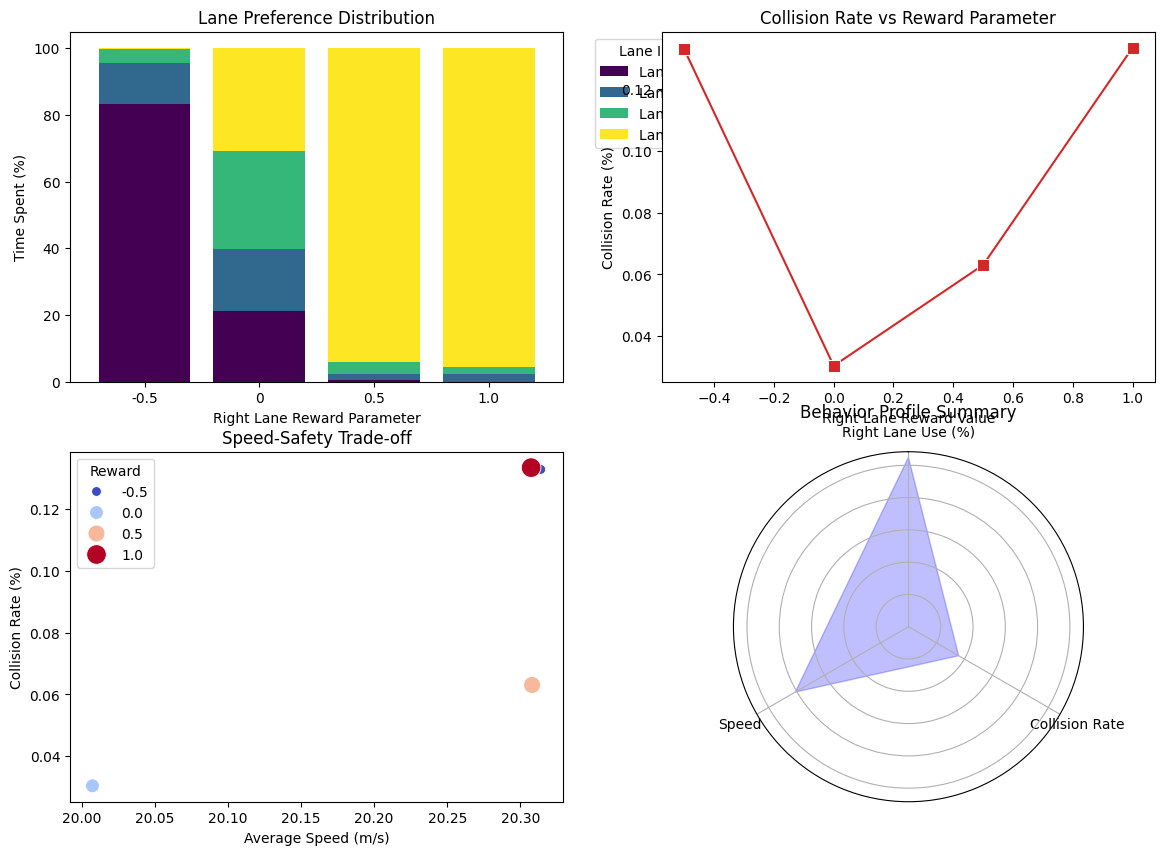

In [ ]:
# Create DataFrame
df = pd.DataFrame(results)

plt.figure(figsize=(14, 10))

# 1. Lane Occupancy Distribution (Stacked Bar)
plt.subplot(2, 2, 1)
df[['Lane 0 (%)', 'Lane 1 (%)', 'Lane 2 (%)', 'Lane 3 (%)']].plot.bar(
    stacked=True,
    colormap='viridis',
    width=0.8,
    ax=plt.gca()
)
plt.title('Lane Preference Distribution')
plt.xlabel('Right Lane Reward Parameter')
plt.xticks(ticks=range(len(LANE_REWARDS)), labels=LANE_REWARDS, rotation=0)
plt.ylabel('Time Spent (%)')
plt.legend(title='Lane Index', bbox_to_anchor=(1.05, 1))

# 2. Crash Rate Analysis
plt.subplot(2, 2, 2)
sns.lineplot(data=df, x='Reward', y='Crash Rate', 
             marker='s', markersize=8, color='#d62728')
plt.title('Collision Rate vs Reward Parameter')
plt.xlabel('Right Lane Reward Value')
plt.ylabel('Collision Rate (%)')

# 3. Speed-Safety Trade-off
plt.subplot(2, 2, 3)
sns.scatterplot(data=df, x='Avg Speed', y='Crash Rate', 
                hue='Reward', size='Reward', sizes=(50, 200),
                palette='coolwarm', legend='full')
plt.title('Speed-Safety Trade-off')
plt.xlabel('Average Speed (m/s)')
plt.ylabel('Collision Rate (%)')

# Reward Impact Radar Chart (Corrected)
plt.subplot(2, 2, 4, polar=True)
categories = ['Right Lane Use (%)', 'Collision Rate', 'Speed']

# Calculate angles with closure
angles = np.linspace(0, 2*np.pi, len(categories), endpoint=False).tolist()
angles += angles[:1]  # Duplicate first angle to close the polygon

# Prepare values with closure
values = [
    df['Lane 0 (%)'].mean(),
    df['Crash Rate'].mean() * 100,
    df['Avg Speed'].mean()
]
values += values[:1]  # Duplicate first value to match angles

# Create radar chart
ax = plt.gca()
ax.fill(angles, values, color='blue', alpha=0.25)
ax.set_theta_offset(np.pi/2)
ax.set_theta_direction(-1)
ax.set_yticklabels([])
plt.xticks(angles[:-1], categories)  # Exclude last duplicate angle
plt.title('Behavior Profile Summary')

### Detailled figures

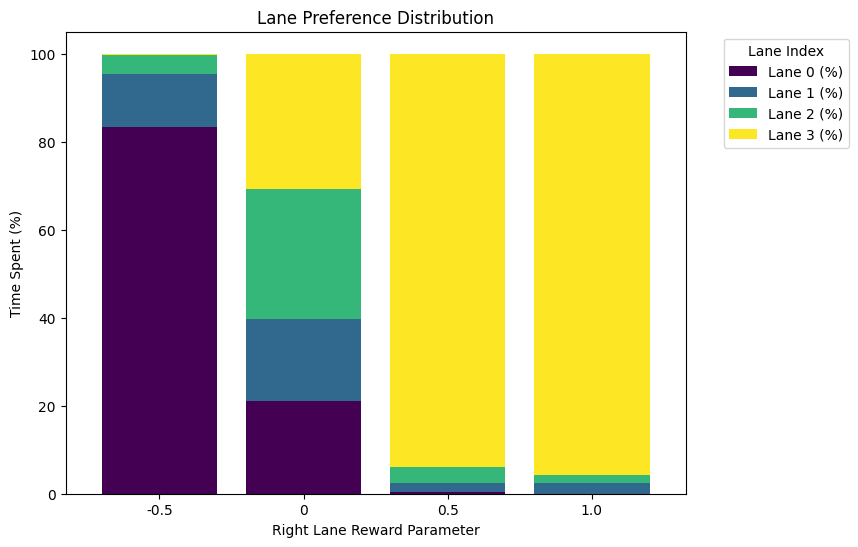

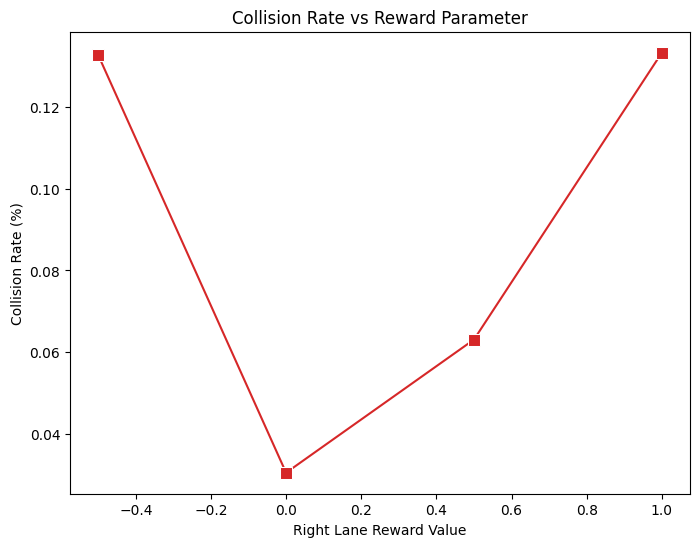

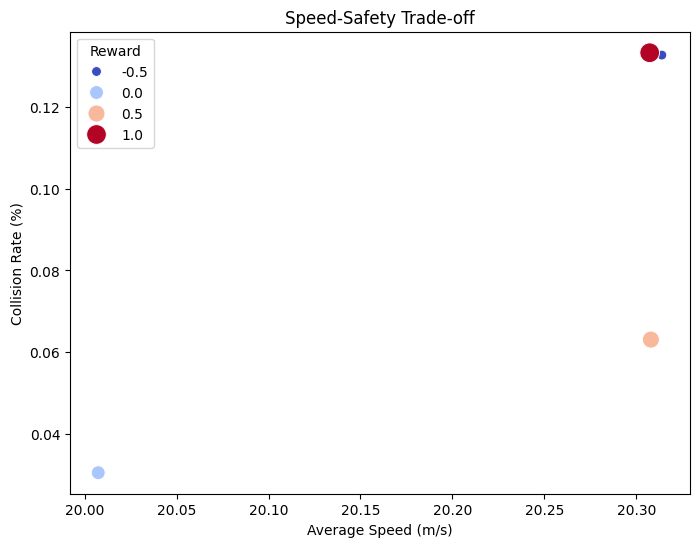

In [ ]:
# 1. Lane Occupancy Distribution (Stacked Bar)
plt.figure(figsize=(8, 6))
df[['Lane 0 (%)', 'Lane 1 (%)', 'Lane 2 (%)', 'Lane 3 (%)']].plot.bar(
    stacked=True,
    colormap='viridis',
    width=0.8,
    ax=plt.gca()
)
plt.title('Lane Preference Distribution')
plt.xlabel('Right Lane Reward Parameter')
plt.xticks(ticks=range(len(LANE_REWARDS)), labels=LANE_REWARDS, rotation=0)
plt.ylabel('Time Spent (%)')
plt.legend(title='Lane Index', bbox_to_anchor=(1.05, 1))
plt.show()

# 2. Crash Rate Analysis
plt.figure(figsize=(8, 6))
sns.lineplot(data=df, x='Reward', y='Crash Rate', 
             marker='s', markersize=8, color='#d62728')
plt.title('Collision Rate vs Reward Parameter')
plt.xlabel('Right Lane Reward Value')
plt.ylabel('Collision Rate (%)')
plt.show()

# 3. Speed-Safety Trade-off
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='Avg Speed', y='Crash Rate', 
                hue='Reward', size='Reward', sizes=(50, 200),
                palette='coolwarm', legend='full')
plt.title('Speed-Safety Trade-off')
plt.xlabel('Average Speed (m/s)')
plt.ylabel('Collision Rate (%)')
plt.show()


### Evaluation - 15 Vehicules

In [ ]:
# %%
# Evaluation and visualization
import psutil   # Cross-platform memory monitoring

import gymnasium as gym
import highway_env
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from stable_baselines3 import DQN

# %%
# Reduced experiment configuration
LANE_REWARDS = [-0.5, 0, 0.5, 1.0]  # 4 key values
N_EPISODES_EVAL = 30  # Reduced evaluation episodes
TRAIN_STEPS = 15_000  # Shorter training

# Check available memory
print(f"Available memory: {psutil.virtual_memory().available / 1e9:.2f} GB")

results = []
for reward in LANE_REWARDS:
    print(f"Evaluating reward={reward}")
    
    # Create modified config for evaluation
    eval_config = config_dict.copy()
    eval_config["right_lane_reward"] = reward
    eval_config["vehicles_count"] = 15  # More vehicles for evaluation
    
    
    # Create SINGLE evaluation environment OUTSIDE episode loop
    eval_env = gym.make("highway-fast-v0", config=eval_config)
    
    # Load model with reduced buffer size for evaluation
    model = DQN.load(
        f"lane_reward_experiment/model_{reward}",
        env=eval_env,  # Attach environment to model
        custom_objects={
            "buffer_size": 1,  # Minimal buffer for evaluation
            "learning_starts": 0
        }
    )

    # Initialize metrics
    crash_count = 0
    lane_time = np.zeros(4)
    speeds = []
    total_steps = 0

    # Evaluate multiple episodes in SAME environment
    for _ in range(N_EPISODES_EVAL):
        obs, _ = eval_env.reset()
        done = False
        
        while not done:
            action, _ = model.predict(obs, deterministic=True)
            obs, _, terminated, truncated, info = eval_env.step(action)
            done = terminated or truncated
            total_steps += 1
            
            # Track lane position
            lane = eval_env.unwrapped.vehicle.lane_index[2]
            if lane < 4:
                lane_time[lane] += 1
                
            # Track speed (assuming observation contains velocity)
            speeds.append(eval_env.unwrapped.vehicle.speed)  # Verify index matches your obs
            
            # Track collisions
            if info.get('crashed', False):
                crash_count += 1

    # Cleanup
    eval_env.close()
    del model  # Explicitly delete model to free memory
    if 'eval_env' in locals():
        del eval_env

    # Calculate metrics
    results.append({
        'Reward': reward,
        'Lane 0 (%)': (lane_time[0]/total_steps)*100,
        'Lane 1 (%)': (lane_time[1]/total_steps)*100,
        'Lane 2 (%)': (lane_time[2]/total_steps)*100,
        'Lane 3 (%)': (lane_time[3]/total_steps)*100,
        'Crash Rate': crash_count / N_EPISODES_EVAL,
        'Avg Speed': np.mean(speeds)
    })



Available memory: 0.59 GB
Evaluating reward=-0.5
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Evaluating reward=0
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Evaluating reward=0.5
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Evaluating reward=1.0
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


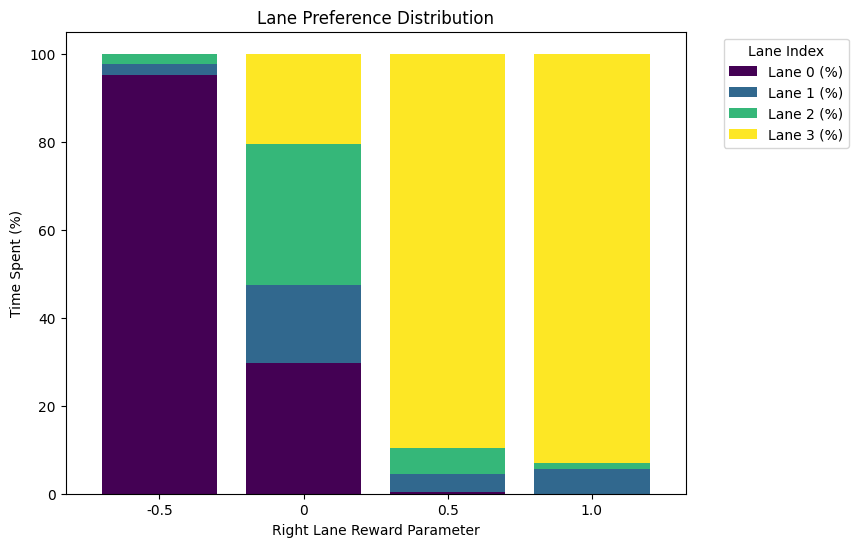

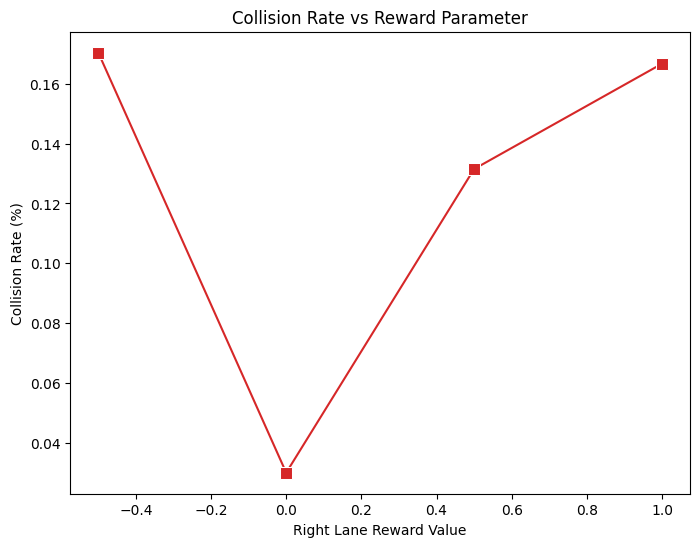

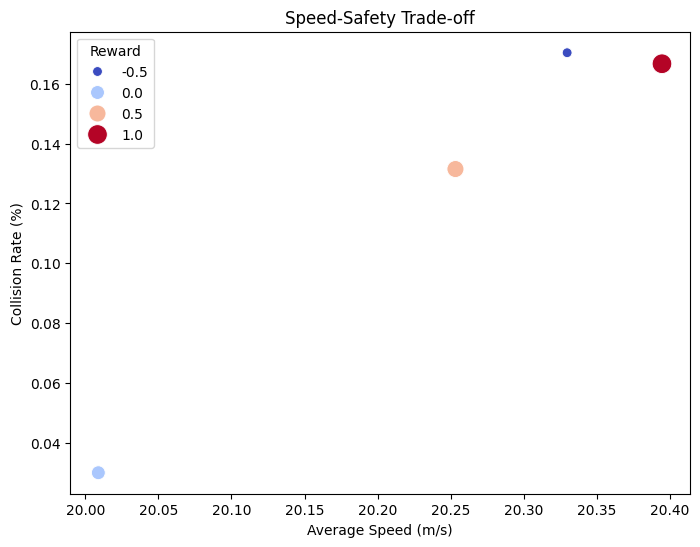

In [23]:
# %%
# Create DataFrame
df = pd.DataFrame(results)

# 1. Lane Occupancy Distribution (Stacked Bar)
plt.figure(figsize=(8, 6))
df[['Lane 0 (%)', 'Lane 1 (%)', 'Lane 2 (%)', 'Lane 3 (%)']].plot.bar(
    stacked=True,
    colormap='viridis',
    width=0.8,
    ax=plt.gca()
)
plt.title('Lane Preference Distribution')
plt.xlabel('Right Lane Reward Parameter')
plt.xticks(ticks=range(len(LANE_REWARDS)), labels=LANE_REWARDS, rotation=0)
plt.ylabel('Time Spent (%)')
plt.legend(title='Lane Index', bbox_to_anchor=(1.05, 1))
plt.show()

# 2. Crash Rate Analysis
plt.figure(figsize=(8, 6))
sns.lineplot(data=df, x='Reward', y='Crash Rate', 
             marker='s', markersize=8, color='#d62728')
plt.title('Collision Rate vs Reward Parameter')
plt.xlabel('Right Lane Reward Value')
plt.ylabel('Collision Rate (%)')
plt.show()

# 3. Speed-Safety Trade-off
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='Avg Speed', y='Crash Rate', 
                hue='Reward', size='Reward', sizes=(50, 200),
                palette='coolwarm', legend='full')
plt.title('Speed-Safety Trade-off')
plt.xlabel('Average Speed (m/s)')
plt.ylabel('Collision Rate (%)')
plt.show()
